# PhotonSim SIREN Cut-off Study

This notebook analyzes the PhotonSim-trained SIREN model to determine optimal cut-off values and sampling coefficients.
It's analogous to `cut_off_study.ipynb` but uses the new PhotonSim SIREN model with actual training ranges.

The main purposes are:
1. Visualize the model's output distribution across different energies
2. Study the relationship between energy and number of valid photon points above threshold
3. Derive linear coefficients for efficient sampling in ray generation
4. Use actual PhotonSim training ranges instead of hardcoded values

In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path
sys.path.append('..')
sys.path.append('../tools')

# Add training modules
training_path = Path('../siren/training')
sys.path.append(str(training_path))

import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
from scipy import interpolate

# Import PhotonSim training modules
from inference import SIRENPredictor

# Import tools
from tools.siren import SIREN
from tools.table import Table
from tools.simulation import create_siren_grid
from tools.generate import generate_random_cone_vectors, normalize, jax_linear_interp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Load the PhotonSim-trained SIREN model
print("Loading PhotonSim SIREN model...")

# Path to your trained model (adjust as needed)
model_base_path = Path('../notebooks/output/photonsim_siren_training/trained_model/photonsim_siren')
photonsim_predictor = SIRENPredictor(model_base_path)

print("✅ PhotonSim SIREN model loaded successfully!")
print(f"Model info: {photonsim_predictor.get_info()['model_config']}")

print("✅ Model loaded and ready for analysis")

Loading PhotonSim SIREN model...
✅ PhotonSim SIREN model loaded successfully!
Model info: {'hidden_features': 256, 'hidden_layers': 3, 'out_features': 1, 'w0': 30.0}
✅ Model loaded and ready for analysis


In [3]:
# Get the actual ranges from PhotonSim training metadata
dataset_info = photonsim_predictor.dataset_info

print(f"PhotonSim Training Data Ranges:")
print(f"  Energy: {dataset_info['energy_range']} MeV")
print(f"  Angle: {np.degrees(dataset_info['angle_range'])} degrees")
print(f"  Distance: {dataset_info['distance_range']} mm")

# Create proper meshes using the actual PhotonSim training ranges
energy_min, energy_max = dataset_info['energy_range']
angle_min, angle_max = dataset_info['angle_range']  # In radians
distance_min, distance_max = dataset_info['distance_range']  # In mm

# Create binning for analysis (using reasonable resolution)
n_angle_bins = 500
n_distance_bins = 500

# Create angle and distance grids using actual training ranges
angle_bins = np.linspace(angle_min, angle_max, n_angle_bins)
distance_bins = np.linspace(distance_min, distance_max, n_distance_bins)

# Convert angles to cos for compatibility with old analysis if needed
cos_bins = np.cos(angle_bins)

print(f"\nAnalysis Grid:")
print(f"  Angle bins: {n_angle_bins} points from {np.degrees(angle_min):.1f}° to {np.degrees(angle_max):.1f}°")
print(f"  Distance bins: {n_distance_bins} points from {distance_min:.0f} to {distance_max:.0f} mm")
print(f"  Total grid points: {n_angle_bins * n_distance_bins:,}")

# Create meshgrids for evaluation
angle_mesh, distance_mesh = np.meshgrid(angle_bins, distance_bins, indexing='ij')
cos_mesh, distance_mesh_cos = np.meshgrid(cos_bins, distance_bins, indexing='ij')

print(f"✅ Using actual PhotonSim training ranges for analysis")

PhotonSim Training Data Ranges:
  Energy: [100.0, 1000.0] MeV
  Angle: [  0.18 179.82] degrees
  Distance: [10.0, 9990.0] mm

Analysis Grid:
  Angle bins: 500 points from 0.2° to 179.8°
  Distance bins: 500 points from 10 to 9990 mm
  Total grid points: 250,000
✅ Using actual PhotonSim training ranges for analysis


## PhotonSim Model Output Visualization

Let's examine the model's output distribution for different energies to understand the scale of predictions using the actual training ranges.

Evaluating PhotonSim model at 500 MeV using actual training ranges...

PhotonSim model output statistics:
  Min: 0.000000
  Max: 413.669434
  Mean: 1.173394
  Std: 11.282789
  Shape: (500, 500)


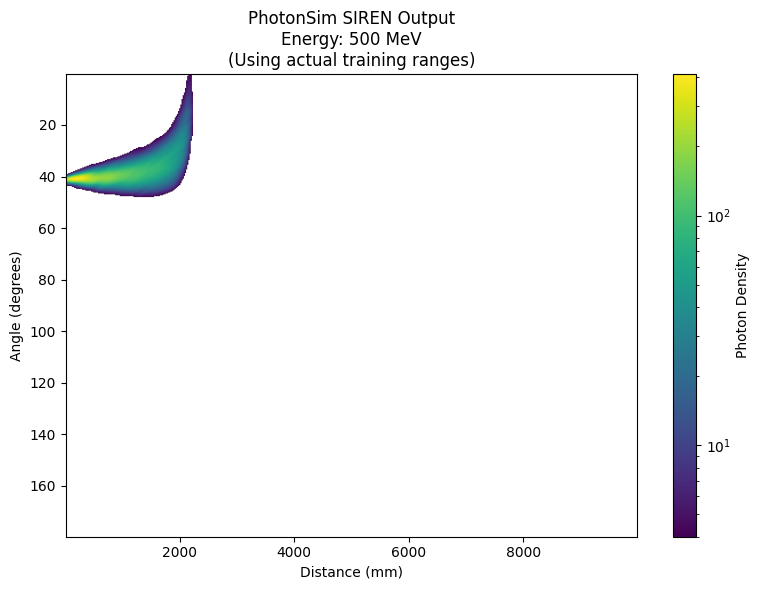


✅ Using actual PhotonSim training ranges:
   Energy: 500 MeV
   Angles: 0.2° to 179.8°
   Distances: 10 to 9990 mm


In [4]:
def evaluate_photonsim_grid(energy, angle_bins, distance_bins, photonsim_predictor):
    """
    Evaluate PhotonSim model on the angle/distance grid for a given energy.
    Uses the actual training ranges from PhotonSim metadata.
    """
    # Create meshgrid using actual PhotonSim ranges
    angle_mesh, distance_mesh = jnp.meshgrid(angle_bins, distance_bins, indexing='ij')
    
    # Create evaluation grid for PhotonSim: [energy, angle, distance]
    # Energy is constant for this slice, angles and distances vary
    evaluation_grid = jnp.stack([
        jnp.full_like(angle_mesh, energy).ravel(),  # Energy (MeV)
        angle_mesh.ravel(),                         # Angle (radians)
        distance_mesh.ravel(),                      # Distance (mm)
    ], axis=1)
    
    # Get predictions using the actual PhotonSim format
    photon_weights = photonsim_predictor.predict_batch(evaluation_grid)
    return np.array(photon_weights).reshape(len(angle_bins), len(distance_bins))

# Test with a single energy using actual PhotonSim ranges
energy = 500  # MeV
print(f"Evaluating PhotonSim model at {energy} MeV using actual training ranges...")

reco_value = evaluate_photonsim_grid(energy, angle_bins, distance_bins, photonsim_predictor)

print(f"\nPhotonSim model output statistics:")
print(f"  Min: {reco_value.min():.6f}")
print(f"  Max: {reco_value.max():.6f}")
print(f"  Mean: {reco_value.mean():.6f}")
print(f"  Std: {reco_value.std():.6f}")
print(f"  Shape: {reco_value.shape}")

# Visualize using proper axis labels
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
fig.patch.set_facecolor('white')

cut_off = 4

reco_value= jnp.where(reco_value>cut_off, reco_value, 0)

# Use appropriate vmin based on the actual data range
vmin = cut_off
im0 = axes.imshow(reco_value, norm=LogNorm(vmin=vmin), aspect='auto',
                  extent=[distance_min, distance_max, np.degrees(angle_max), np.degrees(angle_min)])
fig.colorbar(im0, ax=axes, label='Photon Density')
axes.set_xlabel('Distance (mm)')
axes.set_ylabel('Angle (degrees)')
axes.set_title(f'PhotonSim SIREN Output\nEnergy: {energy} MeV\n(Using actual training ranges)')
fig.tight_layout()
plt.show()

print(f"\n✅ Using actual PhotonSim training ranges:")
print(f"   Energy: {energy} MeV")
print(f"   Angles: {np.degrees(angle_min):.1f}° to {np.degrees(angle_max):.1f}°")
print(f"   Distances: {distance_min:.0f} to {distance_max:.0f} mm")

Processing energy 200 MeV...
  Energy 200 MeV - Min: 0.00e+00, Max: 2.03e+02
    Non-zero fraction: 0.005
Processing energy 500 MeV...
  Energy 500 MeV - Min: 0.00e+00, Max: 4.14e+02
    Non-zero fraction: 0.018
Processing energy 800 MeV...
  Energy 800 MeV - Min: 0.00e+00, Max: 7.00e+02
    Non-zero fraction: 0.028


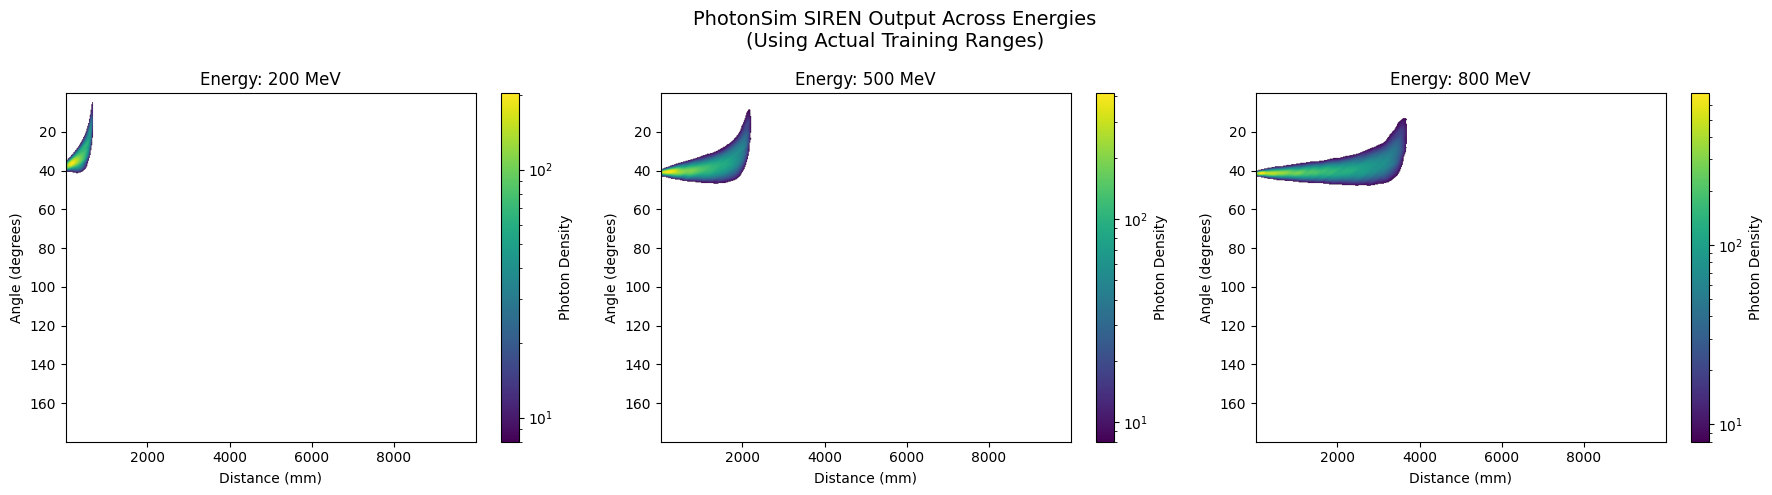


✅ Analysis completed using PhotonSim training ranges:
   Energy range: 100.0-1000.0 MeV
   Angle range: 0.2°-179.8°
   Distance range: 10-9990 mm


In [5]:
# Compare multiple energies using actual PhotonSim ranges
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Use energies within the PhotonSim training range
test_energies = [200, 500, 800]  # MeV - within training range

for i, energy in enumerate(test_energies):
    print(f"Processing energy {energy} MeV...")
    
    reco_value = evaluate_photonsim_grid(energy, angle_bins, distance_bins, photonsim_predictor)
    cut_off = 8.
    reco_value= jnp.where(reco_value>cut_off, reco_value, 0)
    # Use consistent scale across energies for comparison
    vmin = cut_off
    vmax = reco_value.max() if reco_value.max() > vmin else 1e-5
    
    im = axes[i].imshow(reco_value, norm=LogNorm(vmin=vmin, vmax=vmax), aspect='auto',
                        extent=[distance_min, distance_max, np.degrees(angle_max), np.degrees(angle_min)])
    axes[i].set_xlabel('Distance (mm)')
    axes[i].set_ylabel('Angle (degrees)')
    axes[i].set_title(f'Energy: {energy} MeV')
    
    # Add colorbar for each subplot
    fig.colorbar(im, ax=axes[i], label='Photon Density')
    
    print(f"  Energy {energy} MeV - Min: {reco_value.min():.2e}, Max: {reco_value.max():.2e}")
    print(f"    Non-zero fraction: {np.sum(reco_value > 1e-10) / reco_value.size:.3f}")

fig.patch.set_facecolor('white')
fig.suptitle('PhotonSim SIREN Output Across Energies\n(Using Actual Training Ranges)', fontsize=14)
fig.tight_layout()
plt.show()

print(f"\n✅ Analysis completed using PhotonSim training ranges:")
print(f"   Energy range: {energy_min}-{energy_max} MeV")
print(f"   Angle range: {np.degrees(angle_min):.1f}°-{np.degrees(angle_max):.1f}°")
print(f"   Distance range: {distance_min:.0f}-{distance_max:.0f} mm")

## Cut-off Threshold Analysis

Now let's analyze different cut-off thresholds to understand the distribution of "significant" photon weights using actual PhotonSim data.

Cut-off threshold analysis for energy 500 MeV using actual PhotonSim ranges:
Total grid points: 250,000
Grid dimensions: 500 angles × 500 distances
Angle range: 0.2° to 179.8°
Distance range: 10 to 9990 mm

Cut-off threshold analysis:
  1e-01:  36384 points ( 14.6%)
  1e+00:  14521 points (  5.8%)
  8e+00:   4452 points (  1.8%)

Photon weight statistics:
  Min (non-zero): 1.10e-15
  Max: 4.14e+02
  Mean: 1.18e+00
  Median: 2.01e-11
  95th percentile: 1.15e+00


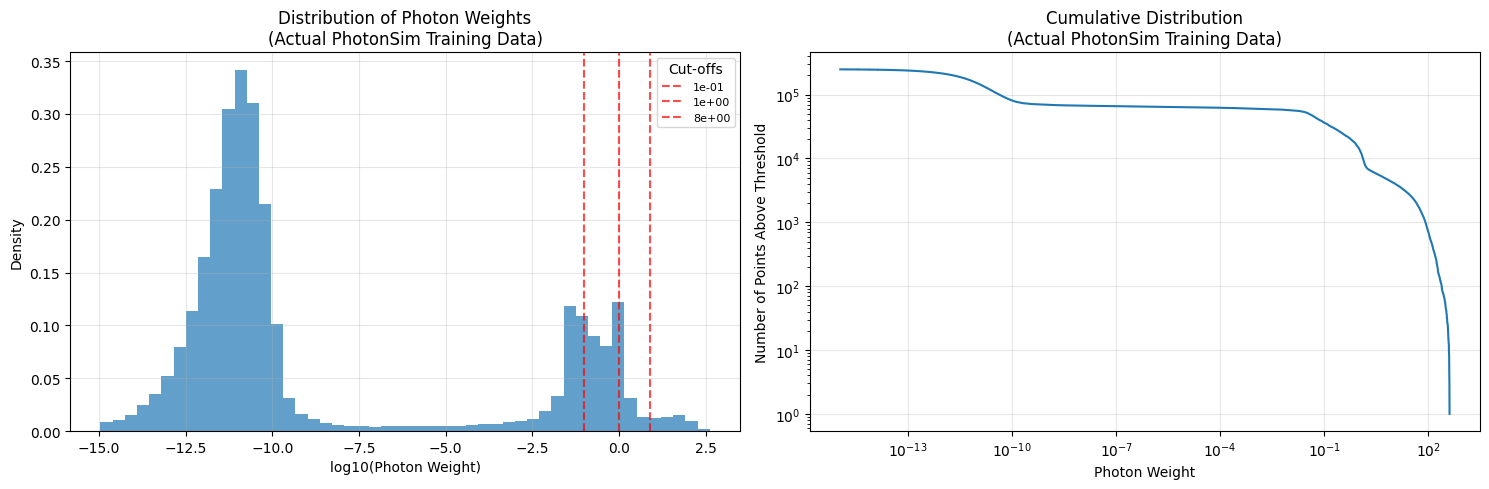


✅ Cut-off analysis using actual PhotonSim training ranges completed


In [6]:
# Analyze cut-off thresholds using actual PhotonSim ranges
energy = 500  # MeV
print(f"Cut-off threshold analysis for energy {energy} MeV using actual PhotonSim ranges:")

reco_value = evaluate_photonsim_grid(energy, angle_bins, distance_bins, photonsim_predictor)
flat_values = reco_value.ravel()

# Test different cut-off values
cut_offs = [0.1, 1., 8.]#[1e-15, 1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2]

print(f"Total grid points: {len(flat_values):,}")
print(f"Grid dimensions: {len(angle_bins)} angles × {len(distance_bins)} distances")
print(f"Angle range: {np.degrees(angle_min):.1f}° to {np.degrees(angle_max):.1f}°")
print(f"Distance range: {distance_min:.0f} to {distance_max:.0f} mm")
print(f"\nCut-off threshold analysis:")

for cut_off in cut_offs:
    count_above = np.sum(flat_values > cut_off)
    percentage = (count_above / len(flat_values)) * 100
    print(f"  {cut_off:.0e}: {count_above:6d} points ({percentage:5.1f}%)")

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of values (excluding zeros/very small values)
valid_values = flat_values[flat_values > 1e-15]
if len(valid_values) > 0:
    axes[0].hist(np.log10(valid_values), bins=50, alpha=0.7, density=True)
    axes[0].set_xlabel('log10(Photon Weight)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distribution of Photon Weights\n(Actual PhotonSim Training Data)')
    axes[0].grid(True, alpha=0.3)
    
    # Add cut-off lines
    for cut_off in cut_offs:#[2:]:  # Skip very small ones
        if cut_off <= valid_values.max():
            axes[0].axvline(np.log10(cut_off), color='red', linestyle='--', alpha=0.7, 
                           label=f'{cut_off:.0e}' if cut_off >= 1e-6 else '')
    axes[0].legend(title='Cut-offs', fontsize=8)
    
    # Cumulative distribution
    sorted_values = np.sort(valid_values)[::-1]  # Sort descending
    cumulative = np.arange(1, len(sorted_values) + 1)
    axes[1].loglog(sorted_values, cumulative)
    axes[1].set_xlabel('Photon Weight')
    axes[1].set_ylabel('Number of Points Above Threshold')
    axes[1].set_title('Cumulative Distribution\n(Actual PhotonSim Training Data)')
    axes[1].grid(True, alpha=0.3)
    
    # Add some statistics
    print(f"\nPhoton weight statistics:")
    print(f"  Min (non-zero): {valid_values.min():.2e}")
    print(f"  Max: {valid_values.max():.2e}")
    print(f"  Mean: {valid_values.mean():.2e}")
    print(f"  Median: {np.median(valid_values):.2e}")
    print(f"  95th percentile: {np.percentile(valid_values, 95):.2e}")
else:
    print("Warning: No valid (non-zero) values found!")

fig.patch.set_facecolor('white')
fig.tight_layout()
plt.show()

print(f"\n✅ Cut-off analysis using actual PhotonSim training ranges completed")

## Energy vs. Valid Points Analysis

Study the relationship between energy and number of valid photon points above different thresholds to derive sampling coefficients using actual PhotonSim ranges.

In [7]:
def photonsim_differentiable_get_rays_analysis(track_origin, track_direction, energy, Nphot, 
                                              photonsim_predictor, angle_bins, distance_bins, key):
    """
    Simplified version of ray generation for analysis purposes using actual PhotonSim ranges.
    Returns photon weights and related information for cut-off analysis.
    """
    # Create evaluation grid using actual PhotonSim training ranges
    angle_mesh, distance_mesh = jnp.meshgrid(angle_bins, distance_bins, indexing='ij')
    
    # Create evaluation grid for PhotonSim: [energy, angle, distance]
    evaluation_grid = jnp.stack([
        jnp.full_like(angle_mesh, energy).ravel(),  # Energy (MeV)
        angle_mesh.ravel(),                         # Angle (radians) 
        distance_mesh.ravel(),                      # Distance (mm)
    ], axis=1)

    # Get photon weights using actual PhotonSim format
    photon_weights = photonsim_predictor.predict_batch(evaluation_grid)
    photon_weights = jnp.array(photon_weights)
    
    # Get top Nphot indices
    top_indices = jnp.argsort(-photon_weights)[:Nphot]
    
    return photon_weights, photon_weights[top_indices]

# Analyze different cut-off thresholds using actual PhotonSim data
cut_off_thresholds = [0.1, 1, 4, 8]

# Use energies within the actual PhotonSim training range
analysis_energies = np.linspace(energy_min, energy_max, 10).astype(int)  # 10 points across range
print(f"Analysis energies: {analysis_energies} MeV")

# Set up simulation parameters
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
key = random.PRNGKey(1)

results = {}

for cut_off in cut_off_thresholds:
    print(f"\nAnalyzing cut-off threshold: {cut_off:.0e}")
    valid_counts = []
    
    for energy in analysis_energies:
        print(f"  Processing energy {energy} MeV...")
        
        Nphot = 50000  # Reasonable number for analysis
        photon_weights, top_weights = photonsim_differentiable_get_rays_analysis(
            origin, direction, energy, Nphot, photonsim_predictor, angle_bins, distance_bins, key
        )
        
        # Count points above threshold
        valid_count = np.sum(photon_weights > cut_off)
        valid_counts.append(valid_count)
        
        print(f"    Valid points above {cut_off:.0e}: {valid_count}")
    
    results[cut_off] = {
        'energies': analysis_energies,
        'valid_counts': valid_counts
    }

print(f"\n✅ Cut-off analysis completed using actual PhotonSim ranges")
print(f"   Total grid points per energy: {len(angle_bins) * len(distance_bins):,}")
print(f"   Energy range analyzed: {analysis_energies[0]}-{analysis_energies[-1]} MeV")

Analysis energies: [ 100  200  300  400  500  600  700  800  900 1000] MeV

Analyzing cut-off threshold: 1e-01
  Processing energy 100 MeV...
    Valid points above 1e-01: 3084
  Processing energy 200 MeV...
    Valid points above 1e-01: 10061
  Processing energy 300 MeV...
    Valid points above 1e-01: 18241
  Processing energy 400 MeV...
    Valid points above 1e-01: 26861
  Processing energy 500 MeV...
    Valid points above 1e-01: 36384
  Processing energy 600 MeV...
    Valid points above 1e-01: 45167
  Processing energy 700 MeV...
    Valid points above 1e-01: 54880
  Processing energy 800 MeV...
    Valid points above 1e-01: 64645
  Processing energy 900 MeV...
    Valid points above 1e-01: 73652
  Processing energy 1000 MeV...
    Valid points above 1e-01: 83634

Analyzing cut-off threshold: 1e+00
  Processing energy 100 MeV...
    Valid points above 1e+00: 649
  Processing energy 200 MeV...
    Valid points above 1e+00: 2390
  Processing energy 300 MeV...
    Valid points abov

Cut-off 1e-01: y = 90.603x + -8170.7, R² = 0.9985
Cut-off 1e+00: y = 44.834x + -6655.3, R² = 0.9906
Cut-off 4e+00: y = 11.659x + -605.4, R² = 0.9973
Cut-off 8e+00: y = 9.509x + -507.8, R² = 0.9971


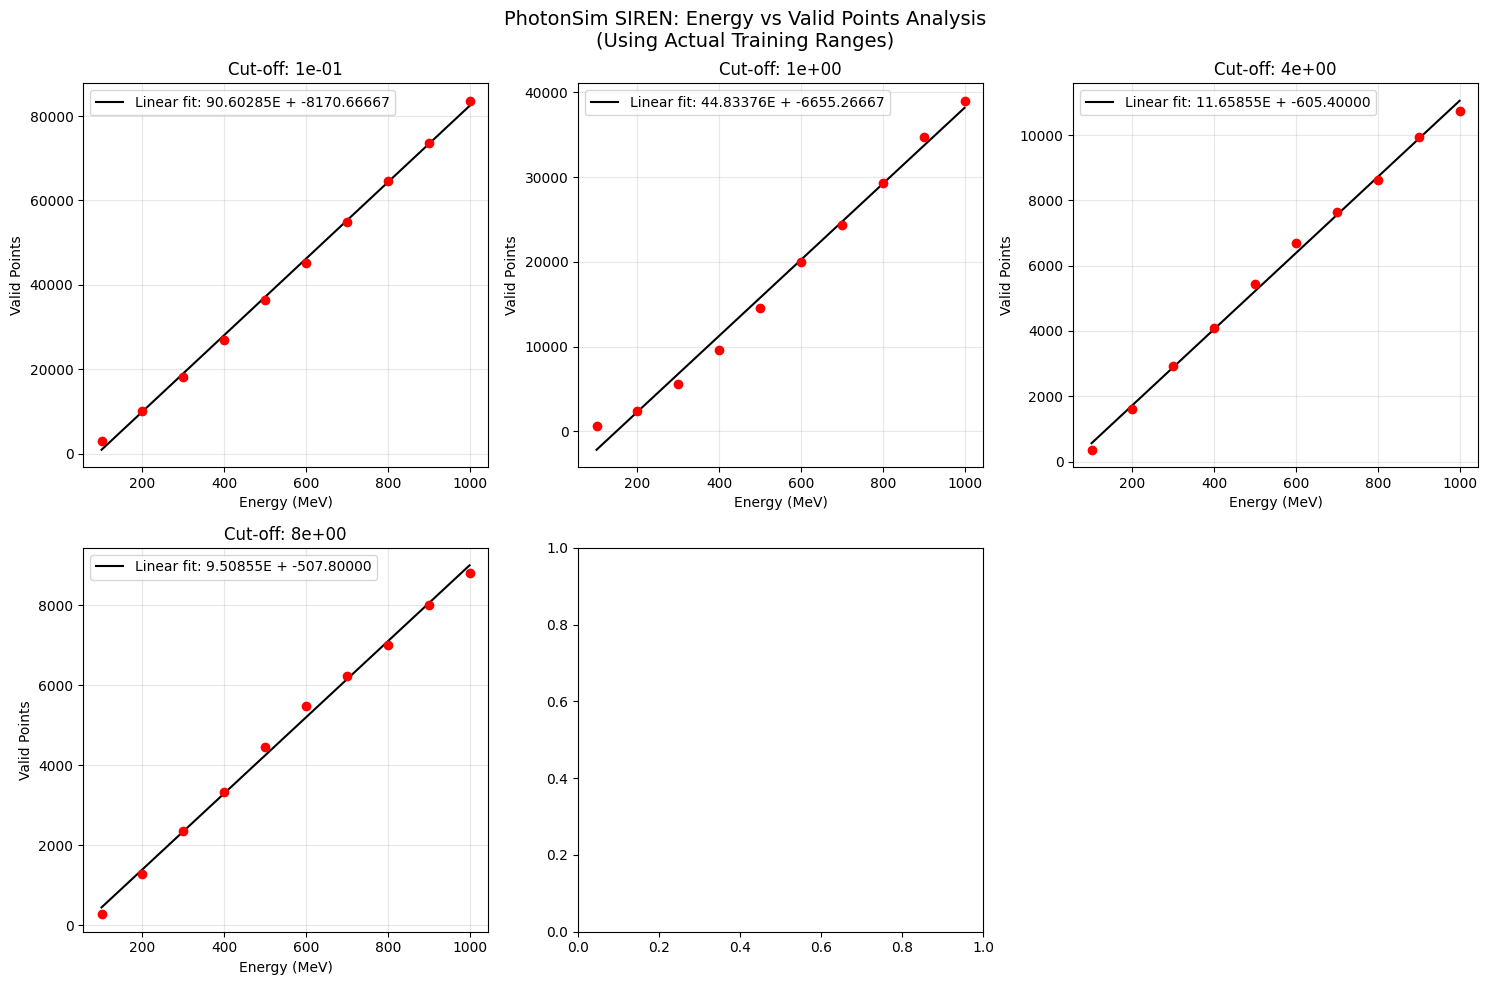

In [9]:
# Visualize results and derive linear coefficients
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

linear_coefficients = {}

for i, cut_off in enumerate(cut_off_thresholds):
    energies_list = results[cut_off]['energies']
    valid_counts = results[cut_off]['valid_counts']
    
    # Fit linear relationship
    coefficients = np.polyfit(energies_list, valid_counts, 1)
    fit_line = np.poly1d(coefficients)
    linear_coefficients[cut_off] = coefficients
    
    # Plot
    axes[i].plot(energies_list, fit_line(energies_list), '-k', 
                label=f'Linear fit: {coefficients[0]:.5f}E + {coefficients[1]:.5f}')
    axes[i].scatter(energies_list, valid_counts, color='red', zorder=10)
    axes[i].set_xlabel('Energy (MeV)')
    axes[i].set_ylabel('Valid Points')
    axes[i].set_title(f'Cut-off: {cut_off:.0e}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Calculate R-squared
    y_pred = fit_line(energies_list)
    ss_res = np.sum((valid_counts - y_pred) ** 2)
    ss_tot = np.sum((valid_counts - np.mean(valid_counts)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    print(f"Cut-off {cut_off:.0e}: y = {coefficients[0]:.3f}x + {coefficients[1]:.1f}, R² = {r_squared:.4f}")

# Remove empty subplot
fig.delaxes(axes[5])

fig.patch.set_facecolor('white')
fig.suptitle('PhotonSim SIREN: Energy vs Valid Points Analysis\n(Using Actual Training Ranges)', fontsize=14)
fig.tight_layout()
plt.show()

## Coefficient Summary and Recommendations

Based on the analysis using actual PhotonSim training ranges, provide recommended coefficients for different cut-off thresholds.

## Model Comparison and Validation

Compare the PhotonSim model characteristics using actual training ranges.